In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join

import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Lambda, Reshape
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.losses import binary_crossentropy, mse
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

from skmultilearn.model_selection import iterative_train_test_split

from tensorflow.contrib.tensorboard.plugins import projector

from global_config import RANDOM_SEED, IMAGE_SIZE, FILE_DUMP_IMAGES, FILE_DUMP_MRKS
from local_config import FOLDER_MODELS, FILE_AUTOENCODER_SAMPLES
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
PATH_TO_ROOT = '../../'

FOLDER_LOGS = join(PATH_TO_ROOT, 'logs')
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DUMP_MRKS = join(PATH_TO_ROOT, FILE_DUMP_MRKS)
FILE_DUMP_IMAGES = join(PATH_TO_ROOT, FILE_DUMP_IMAGES)
FILE_AUTOENCODER_SAMPLES = join(PATH_TO_ROOT, FILE_AUTOENCODER_SAMPLES)

print(FOLDER_LOGS)
print(FOLDER_MODELS)
print(FILE_DUMP_MRKS)
print(FILE_DUMP_IMAGES)
print(FILE_AUTOENCODER_SAMPLES)

../../logs
../../models/unsupervised_supervised/
../../data/cropped_faces/cropped_faces_mrks.pkl
../../data/cropped_faces/cropped_faces_images.pkl
../../data/unsupervised_supervised_samples.pkl


In [3]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Unsupervised + Supervised'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
x, _ = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
mrks, _ = pkl.load(open(FILE_DUMP_MRKS, 'rb'))
y = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])

print(x.shape, x.dtype)
print(y.shape, y.dtype)
print(len(mrks))

(5731, 160, 160, 3) float32
(5731, 23) int32
5731


In [6]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train, x_val_idx, y_val = iterative_train_test_split(np.arange(x.shape[0]).reshape(-1, 1), y, test_size=TEST_SIZE)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5151, 160, 160, 3) (5151, 23)
(580, 160, 160, 3) (580, 23)


In [7]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

# pkl.dump((x_train, x_val, train_mrks, val_mrks), open(FILE_AUTOENCODER_SAMPLES, 'wb'), -1)

# Model Training 

In [8]:
x_train, x_val, _, _ = pkl.load(open(FILE_AUTOENCODER_SAMPLES, 'rb'))
x_train /= 255.0
x_val /= 255.0

print(x_train.shape, x_train.dtype, x_train.min(), x_train.max())
print(x_val.shape, x_val.dtype, x_val.min(), x_val.max())

(5151, 160, 160, 3) float32 0.0 1.0
(580, 160, 160, 3) float32 0.0 1.0


In [9]:
img_height, img_width = IMAGE_SIZE

def sample_z(args):
    mu, sigma = args
    batch_size = K.shape(mu)[0]
    latent_dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch_size, latent_dim))
    return mu + K.exp(0.5 * sigma) * eps


def vae_loss(y_true, y_pred):
    """
    https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py
    https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/
    """
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= (img_width * img_height)
    
    kl_loss = 1 + z_sigma - K.square(z_mean) - K.exp(z_sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)


# def vae_loss(y_true, y_pred):
#     """https://keras.io/examples/generative/vae/#define-the-vae-as-a-model-with-a-custom-trainstep""""
#     reconstruction_loss = tf.reduce_mean(binary_crossentropy(y_true, y_pred))
#     reconstruction_loss *= (img_width * img_height)
    
#     kl_loss = 1 + z_sigma - tf.square(z_mean) - tf.exp(z_sigma)
#     kl_loss = tf.reduce_mean(kl_loss)
#     kl_loss *= -0.5
#     return reconstruction_loss + kl_loss

In [10]:
def conv_bn(idx, prev_input, filters, activation='relu', name=None):
    conv_name = 'conv_' + str(idx)
    bn_name = 'bn_' + str(idx)
    act_name = f'{activation}_' + str(idx) if name is None else name
    
    conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    conv = BatchNormalization(axis=-1, name=bn_name)(conv)
    conv = Activation(activation, name=act_name)(conv)
    return conv


def conv_bn_maxpool(idx, prev_input, filters):
    pool_name = 'pool_' + str(idx)
    
    conv = conv_bn(idx, prev_input, filters)
    pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name=pool_name)(conv)
    return pool


def deconv_bn(idx, prev_input, filters, activation='relu'):
    bn_name = str(idx) + '_bn' 
    act_name = str(idx) + '_relu' 
    conv_name = str(idx) + '_conv' 
    
    deconv = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation=None, name=conv_name)(prev_input)
    deconv = BatchNormalization(axis=-1, name=bn_name)(deconv)
    deconv = Activation(activation, name=act_name)(deconv)
    return deconv


def dense_layer(idx, prev_input, units, dropout=True, rate=0.5, activation='relu'):
    dense_name = f"dense_{idx}"
    drop_name = f"dropout_{idx}"
    
    if dropout:
        prev_input = Dropout(rate, name=drop_name)(prev_input)
    out = Dense(units, activation=activation, name=dense_name)(prev_input)
    return out

In [11]:
set_random_seeds()
LATENT_DIM = 64
N_REQS = y_train.shape[1]

mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.log_param("latent_dim", LATENT_DIM)
mlflow.keras.autolog()

# encoder
inputs = Input(shape=x_train.shape[1:], name='input')
pool_1 = conv_bn_maxpool(1, inputs, 16)
pool_2 = conv_bn_maxpool(2, pool_1, 32)
pool_3 = conv_bn_maxpool(3, pool_2, 64)
pool_4 = conv_bn_maxpool(4, pool_3, 128)
conv_shape = K.int_shape(pool_4)

avg_pool = GlobalAvgPool2D(name='global_avg_pool')(pool_4)
z_mean = Dense(LATENT_DIM, name='z_mean')(avg_pool)
z_sigma = Dense(LATENT_DIM, name='z_sigma')(avg_pool)
z = Lambda(sample_z, output_shape=(LATENT_DIM, ), name='embeddings')([z_mean, z_sigma])

# decoder
dense = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu', name='dense')(z)
reshape = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name='reshape')(dense)
dec_4 = deconv_bn(4, reshape, 128)
dec_3 = deconv_bn(3, dec_4, 64)
dec_2 = deconv_bn(2, dec_3, 32)
dec_1 = deconv_bn(1, dec_2, 16)
decoded = Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='decoded')(dec_1)

# classifier
dense_1 = dense_layer(1, z_mean, 32)
classif = Dense(units=N_REQS, activation='sigmoid', name='outputs')(dense_1)

model = Model(inputs=inputs, outputs=[decoded, classif], name='ICAOnet')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "ICAOnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 16) 0           bn_1[0][0]                       
____________________________________________________________________________________________

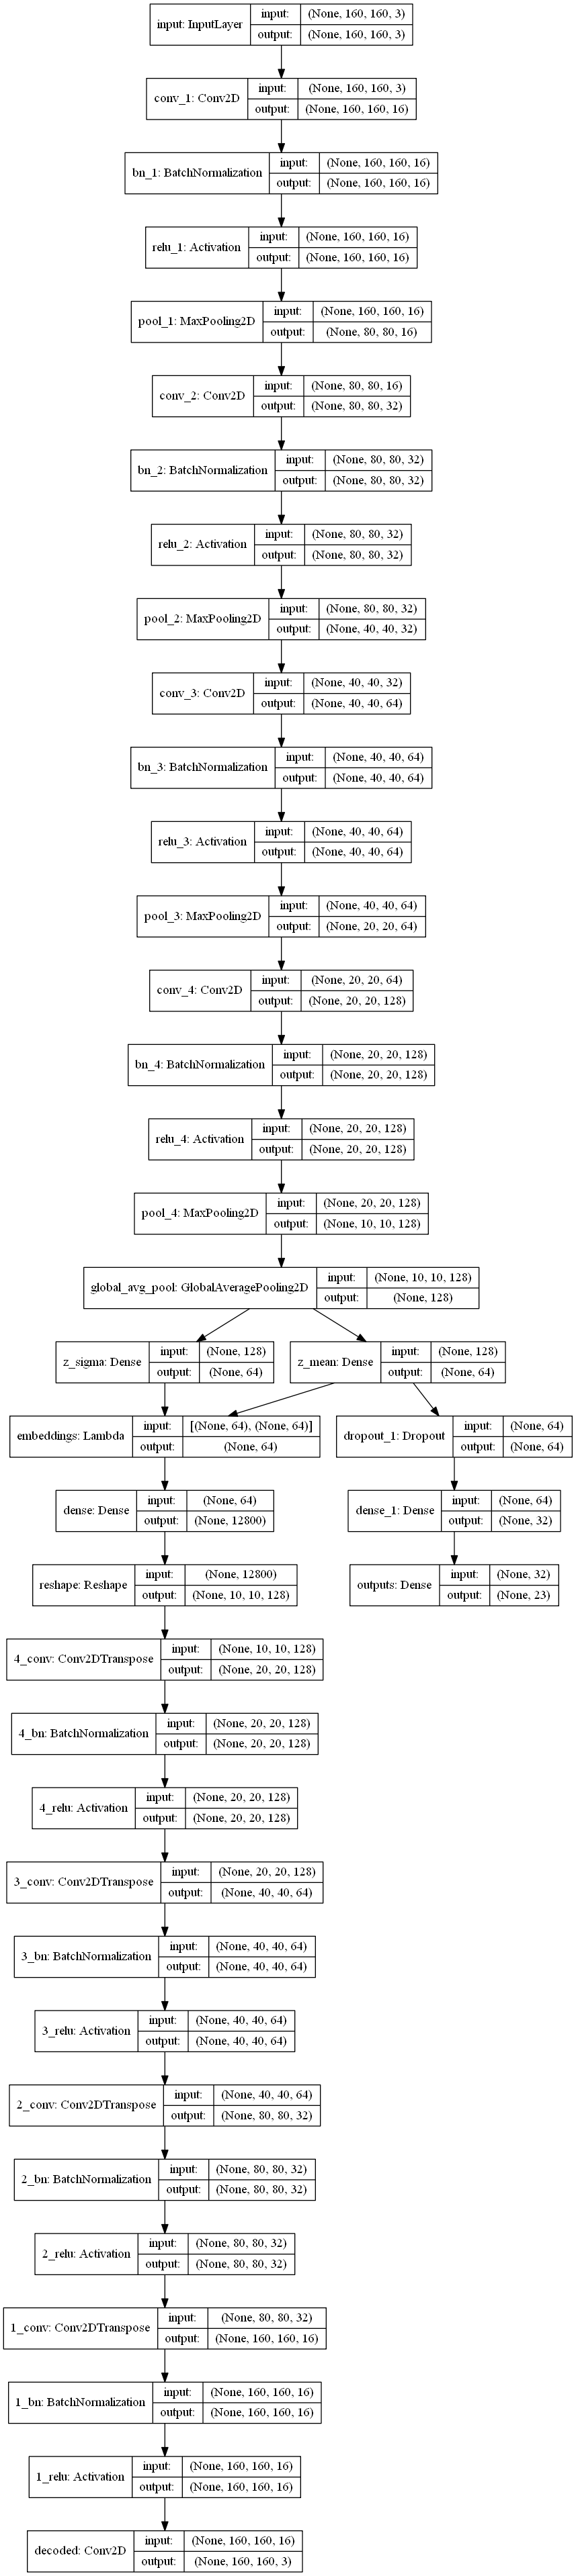

In [12]:
plot_model(model, show_shapes=True)

Instructions for updating:
Use tf.cast instead.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 5151 samples, validate on 580 samples
Epoch 1/200
5151/5151 [==============================] - 31s 6ms/step - loss: 728.3420 - decoded_loss: 1456.0510 - outputs_loss: 0.5604 - outputs_accuracy: 0.7166 - outputs_precision: 0.8262 - outputs_recall: 0.8175 - outputs_f1: 0.8157 - outputs_fbeta: 0.8137 - outputs_specificity: 0.3183 - outputs_negative_predictive_value: 0.3525 - outputs_matthews_correlation_coefficient: 0.1529 - val_loss: 1897.7351 - val_decoded_loss: 3694.5920 - val_outputs_loss: 0.5198 - val_outputs_accuracy: 0.7790 - val_outputs_precision: 0.7971 - val_outputs_recall: 0.9455 - val_outputs_f1: 0.8635 - val_outputs_fbeta: 0.9077 - val_outputs_specificity: 0.1603 - val_outputs_negative_predictive_value: 0.4527 - val_outputs_matthews_correlation_coefficient: 0.1617

Epoch 00001: val_outputs_fbeta improved from -inf to 0.90772, saving model to ../../models/unsupervised_supervised/multilearner_2020_07_19-15_49_52.h5
Epoch 2/200
5151/5151 [==============================]


Epoch 00010: val_outputs_fbeta did not improve from 0.93906
Epoch 11/200
5151/5151 [==============================] - 27s 5ms/step - loss: 286.4001 - decoded_loss: 572.4312 - outputs_loss: 0.3600 - outputs_accuracy: 0.8312 - outputs_precision: 0.8521 - outputs_recall: 0.9544 - outputs_f1: 0.9002 - outputs_fbeta: 0.9291 - outputs_specificity: 0.3432 - outputs_negative_predictive_value: 0.6533 - outputs_matthews_correlation_coefficient: 0.3874 - val_loss: 407.3784 - val_decoded_loss: 808.6641 - val_outputs_loss: 0.3391 - val_outputs_accuracy: 0.8489 - val_outputs_precision: 0.8574 - val_outputs_recall: 0.9532 - val_outputs_f1: 0.9015 - val_outputs_fbeta: 0.9294 - val_outputs_specificity: 0.4526 - val_outputs_negative_predictive_value: 0.7251 - val_outputs_matthews_correlation_coefficient: 0.4853

Epoch 00011: val_outputs_fbeta did not improve from 0.93906
Epoch 12/200
5151/5151 [==============================] - 27s 5ms/step - loss: 277.6505 - decoded_loss: 554.9407 - outputs_loss: 0.35


Epoch 00020: val_outputs_fbeta did not improve from 0.94185
Epoch 21/200
5151/5151 [==============================] - 27s 5ms/step - loss: 245.8703 - decoded_loss: 491.4015 - outputs_loss: 0.3477 - outputs_accuracy: 0.8385 - outputs_precision: 0.8596 - outputs_recall: 0.9537 - outputs_f1: 0.9040 - outputs_fbeta: 0.9302 - outputs_specificity: 0.3830 - outputs_negative_predictive_value: 0.6754 - outputs_matthews_correlation_coefficient: 0.4238 - val_loss: 447.0595 - val_decoded_loss: 881.7506 - val_outputs_loss: 0.3238 - val_outputs_accuracy: 0.8525 - val_outputs_precision: 0.8559 - val_outputs_recall: 0.9602 - val_outputs_f1: 0.9039 - val_outputs_fbeta: 0.9346 - val_outputs_specificity: 0.4432 - val_outputs_negative_predictive_value: 0.7548 - val_outputs_matthews_correlation_coefficient: 0.4956

Epoch 00021: val_outputs_fbeta did not improve from 0.94185
Epoch 22/200
5151/5151 [==============================] - 27s 5ms/step - loss: 239.9591 - decoded_loss: 479.5795 - outputs_loss: 0.34

5151/5151 [==============================] - 27s 5ms/step - loss: 220.6477 - decoded_loss: 440.9604 - outputs_loss: 0.3426 - outputs_accuracy: 0.8403 - outputs_precision: 0.8625 - outputs_recall: 0.9520 - outputs_f1: 0.9049 - outputs_fbeta: 0.9296 - outputs_specificity: 0.3978 - outputs_negative_predictive_value: 0.6762 - outputs_matthews_correlation_coefficient: 0.4335 - val_loss: 344.7750 - val_decoded_loss: 685.1902 - val_outputs_loss: 0.3180 - val_outputs_accuracy: 0.8627 - val_outputs_precision: 0.8614 - val_outputs_recall: 0.9683 - val_outputs_f1: 0.9106 - val_outputs_fbeta: 0.9422 - val_outputs_specificity: 0.4641 - val_outputs_negative_predictive_value: 0.7991 - val_outputs_matthews_correlation_coefficient: 0.5336

Epoch 00031: val_outputs_fbeta improved from 0.94209 to 0.94216, saving model to ../../models/unsupervised_supervised/multilearner_2020_07_19-15_49_52.h5
Epoch 32/200
5151/5151 [==============================] - 27s 5ms/step - loss: 216.8417 - decoded_loss: 433.3471 


Epoch 00040: val_outputs_fbeta did not improve from 0.94794
Epoch 41/200
5151/5151 [==============================] - 27s 5ms/step - loss: 204.3496 - decoded_loss: 408.3627 - outputs_loss: 0.3386 - outputs_accuracy: 0.8433 - outputs_precision: 0.8648 - outputs_recall: 0.9528 - outputs_f1: 0.9065 - outputs_fbeta: 0.9307 - outputs_specificity: 0.4093 - outputs_negative_predictive_value: 0.6847 - outputs_matthews_correlation_coefficient: 0.4456 - val_loss: 302.9718 - val_decoded_loss: 602.5755 - val_outputs_loss: 0.2855 - val_outputs_accuracy: 0.8836 - val_outputs_precision: 0.8867 - val_outputs_recall: 0.9616 - val_outputs_f1: 0.9210 - val_outputs_fbeta: 0.9431 - val_outputs_specificity: 0.5893 - val_outputs_negative_predictive_value: 0.8067 - val_outputs_matthews_correlation_coefficient: 0.6166

Epoch 00041: val_outputs_fbeta did not improve from 0.94794
Epoch 42/200
5151/5151 [==============================] - 27s 5ms/step - loss: 202.8512 - decoded_loss: 405.3602 - outputs_loss: 0.34

5151/5151 [==============================] - 27s 5ms/step - loss: 191.7575 - decoded_loss: 383.1764 - outputs_loss: 0.3380 - outputs_accuracy: 0.8444 - outputs_precision: 0.8671 - outputs_recall: 0.9510 - outputs_f1: 0.9070 - outputs_fbeta: 0.9301 - outputs_specificity: 0.4217 - outputs_negative_predictive_value: 0.6847 - outputs_matthews_correlation_coefficient: 0.4529 - val_loss: 309.3971 - val_decoded_loss: 613.3286 - val_outputs_loss: 0.2855 - val_outputs_accuracy: 0.8883 - val_outputs_precision: 0.8889 - val_outputs_recall: 0.9668 - val_outputs_f1: 0.9250 - val_outputs_fbeta: 0.9482 - val_outputs_specificity: 0.5925 - val_outputs_negative_predictive_value: 0.8303 - val_outputs_matthews_correlation_coefficient: 0.6332

Epoch 00051: val_outputs_fbeta did not improve from 0.94825
Epoch 52/200
5151/5151 [==============================] - 27s 5ms/step - loss: 190.7235 - decoded_loss: 381.1197 - outputs_loss: 0.3367 - outputs_accuracy: 0.8443 - outputs_precision: 0.8664 - outputs_recall


Epoch 00060: val_outputs_fbeta did not improve from 0.95039
Epoch 61/200
5151/5151 [==============================] - 27s 5ms/step - loss: 181.2497 - decoded_loss: 362.1570 - outputs_loss: 0.3367 - outputs_accuracy: 0.8441 - outputs_precision: 0.8670 - outputs_recall: 0.9508 - outputs_f1: 0.9068 - outputs_fbeta: 0.9300 - outputs_specificity: 0.4212 - outputs_negative_predictive_value: 0.6836 - outputs_matthews_correlation_coefficient: 0.4519 - val_loss: 290.6277 - val_decoded_loss: 575.3541 - val_outputs_loss: 0.2817 - val_outputs_accuracy: 0.8877 - val_outputs_precision: 0.8845 - val_outputs_recall: 0.9697 - val_outputs_f1: 0.9233 - val_outputs_fbeta: 0.9485 - val_outputs_specificity: 0.5763 - val_outputs_negative_predictive_value: 0.8400 - val_outputs_matthews_correlation_coefficient: 0.6267

Epoch 00061: val_outputs_fbeta did not improve from 0.95039
Epoch 62/200
5151/5151 [==============================] - 27s 5ms/step - loss: 178.2132 - decoded_loss: 356.1035 - outputs_loss: 0.33

5151/5151 [==============================] - 27s 5ms/step - loss: 174.4176 - decoded_loss: 348.5020 - outputs_loss: 0.3361 - outputs_accuracy: 0.8452 - outputs_precision: 0.8669 - outputs_recall: 0.9525 - outputs_f1: 0.9076 - outputs_fbeta: 0.9310 - outputs_specificity: 0.4193 - outputs_negative_predictive_value: 0.6890 - outputs_matthews_correlation_coefficient: 0.4541 - val_loss: 288.2394 - val_decoded_loss: 569.1723 - val_outputs_loss: 0.2797 - val_outputs_accuracy: 0.8881 - val_outputs_precision: 0.8851 - val_outputs_recall: 0.9698 - val_outputs_f1: 0.9244 - val_outputs_fbeta: 0.9494 - val_outputs_specificity: 0.5787 - val_outputs_negative_predictive_value: 0.8417 - val_outputs_matthews_correlation_coefficient: 0.6304

Epoch 00071: val_outputs_fbeta did not improve from 0.95048
Epoch 72/200
5151/5151 [==============================] - 27s 5ms/step - loss: 171.1811 - decoded_loss: 342.0220 - outputs_loss: 0.3346 - outputs_accuracy: 0.8457 - outputs_precision: 0.8684 - outputs_recall


Epoch 00080: val_outputs_fbeta did not improve from 0.95350
Epoch 81/200
5151/5151 [==============================] - 27s 5ms/step - loss: 165.7029 - decoded_loss: 331.0684 - outputs_loss: 0.3329 - outputs_accuracy: 0.8472 - outputs_precision: 0.8698 - outputs_recall: 0.9513 - outputs_f1: 0.9085 - outputs_fbeta: 0.9309 - outputs_specificity: 0.4346 - outputs_negative_predictive_value: 0.6911 - outputs_matthews_correlation_coefficient: 0.4645 - val_loss: 284.4492 - val_decoded_loss: 563.8123 - val_outputs_loss: 0.2861 - val_outputs_accuracy: 0.8857 - val_outputs_precision: 0.8880 - val_outputs_recall: 0.9659 - val_outputs_f1: 0.9240 - val_outputs_fbeta: 0.9474 - val_outputs_specificity: 0.5897 - val_outputs_negative_predictive_value: 0.8231 - val_outputs_matthews_correlation_coefficient: 0.6274

Epoch 00081: val_outputs_fbeta did not improve from 0.95350
Epoch 82/200
5151/5151 [==============================] - 27s 5ms/step - loss: 165.4473 - decoded_loss: 330.5592 - outputs_loss: 0.33

5151/5151 [==============================] - 27s 5ms/step - loss: 159.2026 - decoded_loss: 318.0800 - outputs_loss: 0.3322 - outputs_accuracy: 0.8481 - outputs_precision: 0.8699 - outputs_recall: 0.9523 - outputs_f1: 0.9091 - outputs_fbeta: 0.9319 - outputs_specificity: 0.4359 - outputs_negative_predictive_value: 0.6964 - outputs_matthews_correlation_coefficient: 0.4683 - val_loss: 288.4086 - val_decoded_loss: 570.7426 - val_outputs_loss: 0.2690 - val_outputs_accuracy: 0.8945 - val_outputs_precision: 0.8904 - val_outputs_recall: 0.9722 - val_outputs_f1: 0.9279 - val_outputs_fbeta: 0.9525 - val_outputs_specificity: 0.6029 - val_outputs_negative_predictive_value: 0.8559 - val_outputs_matthews_correlation_coefficient: 0.6536

Epoch 00091: val_outputs_fbeta did not improve from 0.95370
Epoch 92/200
5151/5151 [==============================] - 27s 5ms/step - loss: 160.5359 - decoded_loss: 320.7360 - outputs_loss: 0.3326 - outputs_accuracy: 0.8474 - outputs_precision: 0.8710 - outputs_recall

5151/5151 [==============================] - 27s 5ms/step - loss: 154.7209 - decoded_loss: 309.1069 - outputs_loss: 0.3333 - outputs_accuracy: 0.8485 - outputs_precision: 0.8707 - outputs_recall: 0.9518 - outputs_f1: 0.9093 - outputs_fbeta: 0.9316 - outputs_specificity: 0.4402 - outputs_negative_predictive_value: 0.6961 - outputs_matthews_correlation_coefficient: 0.4706 - val_loss: 266.6758 - val_decoded_loss: 528.7748 - val_outputs_loss: 0.2680 - val_outputs_accuracy: 0.8960 - val_outputs_precision: 0.8964 - val_outputs_recall: 0.9663 - val_outputs_f1: 0.9294 - val_outputs_fbeta: 0.9504 - val_outputs_specificity: 0.6278 - val_outputs_negative_predictive_value: 0.8415 - val_outputs_matthews_correlation_coefficient: 0.6613

Epoch 00101: val_outputs_fbeta did not improve from 0.95370
Epoch 102/200
5151/5151 [==============================] - 27s 5ms/step - loss: 153.6278 - decoded_loss: 306.9275 - outputs_loss: 0.3333 - outputs_accuracy: 0.8474 - outputs_precision: 0.8708 - outputs_recal

5151/5151 [==============================] - 27s 5ms/step - loss: 150.0226 - decoded_loss: 299.7094 - outputs_loss: 0.3321 - outputs_accuracy: 0.8480 - outputs_precision: 0.8713 - outputs_recall: 0.9502 - outputs_f1: 0.9089 - outputs_fbeta: 0.9304 - outputs_specificity: 0.4428 - outputs_negative_predictive_value: 0.6905 - outputs_matthews_correlation_coefficient: 0.4692 - val_loss: 276.6455 - val_decoded_loss: 547.7764 - val_outputs_loss: 0.2803 - val_outputs_accuracy: 0.8836 - val_outputs_precision: 0.8749 - val_outputs_recall: 0.9811 - val_outputs_f1: 0.9240 - val_outputs_fbeta: 0.9552 - val_outputs_specificity: 0.5216 - val_outputs_negative_predictive_value: 0.8838 - val_outputs_matthews_correlation_coefficient: 0.6169

Epoch 00111: val_outputs_fbeta improved from 0.95509 to 0.95523, saving model to ../../models/unsupervised_supervised/multilearner_2020_07_19-15_49_52.h5
Epoch 112/200
5151/5151 [==============================] - 27s 5ms/step - loss: 149.0009 - decoded_loss: 297.6731

5151/5151 [==============================] - 27s 5ms/step - loss: 146.1620 - decoded_loss: 291.9890 - outputs_loss: 0.3322 - outputs_accuracy: 0.8499 - outputs_precision: 0.8719 - outputs_recall: 0.9523 - outputs_f1: 0.9101 - outputs_fbeta: 0.9325 - outputs_specificity: 0.4436 - outputs_negative_predictive_value: 0.7000 - outputs_matthews_correlation_coefficient: 0.4749 - val_loss: 275.5521 - val_decoded_loss: 544.2699 - val_outputs_loss: 0.2791 - val_outputs_accuracy: 0.8837 - val_outputs_precision: 0.8752 - val_outputs_recall: 0.9771 - val_outputs_f1: 0.9220 - val_outputs_fbeta: 0.9521 - val_outputs_specificity: 0.5302 - val_outputs_negative_predictive_value: 0.8657 - val_outputs_matthews_correlation_coefficient: 0.6120

Epoch 00121: val_outputs_fbeta did not improve from 0.95568
Epoch 122/200
5151/5151 [==============================] - 27s 5ms/step - loss: 146.8107 - decoded_loss: 293.2962 - outputs_loss: 0.3295 - outputs_accuracy: 0.8491 - outputs_precision: 0.8710 - outputs_recal

5151/5151 [==============================] - 27s 5ms/step - loss: 142.5189 - decoded_loss: 284.7060 - outputs_loss: 0.3313 - outputs_accuracy: 0.8504 - outputs_precision: 0.8722 - outputs_recall: 0.9523 - outputs_f1: 0.9103 - outputs_fbeta: 0.9324 - outputs_specificity: 0.4462 - outputs_negative_predictive_value: 0.7014 - outputs_matthews_correlation_coefficient: 0.4774 - val_loss: 282.1062 - val_decoded_loss: 554.8862 - val_outputs_loss: 0.2898 - val_outputs_accuracy: 0.8786 - val_outputs_precision: 0.8681 - val_outputs_recall: 0.9799 - val_outputs_f1: 0.9191 - val_outputs_fbeta: 0.9519 - val_outputs_specificity: 0.4932 - val_outputs_negative_predictive_value: 0.8763 - val_outputs_matthews_correlation_coefficient: 0.5914

Epoch 00131: val_outputs_fbeta did not improve from 0.95583
Epoch 132/200
5151/5151 [==============================] - 27s 5ms/step - loss: 142.0021 - decoded_loss: 283.6762 - outputs_loss: 0.3317 - outputs_accuracy: 0.8495 - outputs_precision: 0.8716 - outputs_recal

5151/5151 [==============================] - 27s 5ms/step - loss: 142.0077 - decoded_loss: 283.6825 - outputs_loss: 0.3318 - outputs_accuracy: 0.8501 - outputs_precision: 0.8729 - outputs_recall: 0.9509 - outputs_f1: 0.9101 - outputs_fbeta: 0.9315 - outputs_specificity: 0.4509 - outputs_negative_predictive_value: 0.6976 - outputs_matthews_correlation_coefficient: 0.4781 - val_loss: 278.0345 - val_decoded_loss: 550.0212 - val_outputs_loss: 0.2632 - val_outputs_accuracy: 0.8944 - val_outputs_precision: 0.8924 - val_outputs_recall: 0.9704 - val_outputs_f1: 0.9287 - val_outputs_fbeta: 0.9520 - val_outputs_specificity: 0.6094 - val_outputs_negative_predictive_value: 0.8505 - val_outputs_matthews_correlation_coefficient: 0.6553

Epoch 00141: val_outputs_fbeta did not improve from 0.95647
Epoch 142/200
5151/5151 [==============================] - 27s 5ms/step - loss: 140.5789 - decoded_loss: 280.8351 - outputs_loss: 0.3327 - outputs_accuracy: 0.8486 - outputs_precision: 0.8715 - outputs_recal

5151/5151 [==============================] - 27s 5ms/step - loss: 138.8363 - decoded_loss: 277.3446 - outputs_loss: 0.3308 - outputs_accuracy: 0.8494 - outputs_precision: 0.8714 - outputs_recall: 0.9520 - outputs_f1: 0.9098 - outputs_fbeta: 0.9319 - outputs_specificity: 0.4421 - outputs_negative_predictive_value: 0.6983 - outputs_matthews_correlation_coefficient: 0.4731 - val_loss: 267.8175 - val_decoded_loss: 529.7936 - val_outputs_loss: 0.2635 - val_outputs_accuracy: 0.8995 - val_outputs_precision: 0.8934 - val_outputs_recall: 0.9770 - val_outputs_f1: 0.9323 - val_outputs_fbeta: 0.9572 - val_outputs_specificity: 0.6115 - val_outputs_negative_predictive_value: 0.8793 - val_outputs_matthews_correlation_coefficient: 0.6733

Epoch 00151: val_outputs_fbeta did not improve from 0.95818
Epoch 152/200
5151/5151 [==============================] - 27s 5ms/step - loss: 138.2595 - decoded_loss: 276.1922 - outputs_loss: 0.3314 - outputs_accuracy: 0.8499 - outputs_precision: 0.8720 - outputs_recal

5151/5151 [==============================] - 27s 5ms/step - loss: 135.2115 - decoded_loss: 270.1004 - outputs_loss: 0.3289 - outputs_accuracy: 0.8517 - outputs_precision: 0.8732 - outputs_recall: 0.9527 - outputs_f1: 0.9111 - outputs_fbeta: 0.9329 - outputs_specificity: 0.4496 - outputs_negative_predictive_value: 0.7051 - outputs_matthews_correlation_coefficient: 0.4816 - val_loss: 268.6323 - val_decoded_loss: 531.8127 - val_outputs_loss: 0.2487 - val_outputs_accuracy: 0.9052 - val_outputs_precision: 0.9021 - val_outputs_recall: 0.9740 - val_outputs_f1: 0.9356 - val_outputs_fbeta: 0.9571 - val_outputs_specificity: 0.6516 - val_outputs_negative_predictive_value: 0.8719 - val_outputs_matthews_correlation_coefficient: 0.6947

Epoch 00161: val_outputs_fbeta did not improve from 0.95916
Epoch 162/200
5151/5151 [==============================] - 27s 5ms/step - loss: 135.5326 - decoded_loss: 270.7342 - outputs_loss: 0.3295 - outputs_accuracy: 0.8496 - outputs_precision: 0.8725 - outputs_recal

5151/5151 [==============================] - 27s 5ms/step - loss: 134.3731 - decoded_loss: 268.4160 - outputs_loss: 0.3297 - outputs_accuracy: 0.8503 - outputs_precision: 0.8724 - outputs_recall: 0.9520 - outputs_f1: 0.9103 - outputs_fbeta: 0.9323 - outputs_specificity: 0.4465 - outputs_negative_predictive_value: 0.6996 - outputs_matthews_correlation_coefficient: 0.4767 - val_loss: 265.5319 - val_decoded_loss: 525.7137 - val_outputs_loss: 0.2512 - val_outputs_accuracy: 0.9049 - val_outputs_precision: 0.9026 - val_outputs_recall: 0.9716 - val_outputs_f1: 0.9344 - val_outputs_fbeta: 0.9551 - val_outputs_specificity: 0.6570 - val_outputs_negative_predictive_value: 0.8630 - val_outputs_matthews_correlation_coefficient: 0.6923

Epoch 00171: val_outputs_fbeta did not improve from 0.95916
Epoch 172/200
5151/5151 [==============================] - 27s 5ms/step - loss: 134.1818 - decoded_loss: 268.0296 - outputs_loss: 0.3303 - outputs_accuracy: 0.8496 - outputs_precision: 0.8715 - outputs_recal

5151/5151 [==============================] - 27s 5ms/step - loss: 132.7310 - decoded_loss: 265.1285 - outputs_loss: 0.3317 - outputs_accuracy: 0.8486 - outputs_precision: 0.8716 - outputs_recall: 0.9506 - outputs_f1: 0.9092 - outputs_fbeta: 0.9308 - outputs_specificity: 0.4438 - outputs_negative_predictive_value: 0.6932 - outputs_matthews_correlation_coefficient: 0.4713 - val_loss: 277.7265 - val_decoded_loss: 547.3234 - val_outputs_loss: 0.2592 - val_outputs_accuracy: 0.8983 - val_outputs_precision: 0.8996 - val_outputs_recall: 0.9687 - val_outputs_f1: 0.9320 - val_outputs_fbeta: 0.9528 - val_outputs_specificity: 0.6400 - val_outputs_negative_predictive_value: 0.8495 - val_outputs_matthews_correlation_coefficient: 0.6741

Epoch 00181: val_outputs_fbeta did not improve from 0.95916
Epoch 182/200
5151/5151 [==============================] - 27s 5ms/step - loss: 131.8855 - decoded_loss: 263.4364 - outputs_loss: 0.3289 - outputs_accuracy: 0.8503 - outputs_precision: 0.8730 - outputs_recal

5151/5151 [==============================] - 27s 5ms/step - loss: 129.3474 - decoded_loss: 258.3665 - outputs_loss: 0.3308 - outputs_accuracy: 0.8485 - outputs_precision: 0.8712 - outputs_recall: 0.9511 - outputs_f1: 0.9092 - outputs_fbeta: 0.9312 - outputs_specificity: 0.4421 - outputs_negative_predictive_value: 0.6945 - outputs_matthews_correlation_coefficient: 0.4710 - val_loss: 269.7825 - val_decoded_loss: 535.0056 - val_outputs_loss: 0.2519 - val_outputs_accuracy: 0.9070 - val_outputs_precision: 0.9062 - val_outputs_recall: 0.9713 - val_outputs_f1: 0.9366 - val_outputs_fbeta: 0.9564 - val_outputs_specificity: 0.6702 - val_outputs_negative_predictive_value: 0.8666 - val_outputs_matthews_correlation_coefficient: 0.7028

Epoch 00191: val_outputs_fbeta did not improve from 0.95916
Epoch 192/200
5151/5151 [==============================] - 27s 5ms/step - loss: 130.5109 - decoded_loss: 260.6930 - outputs_loss: 0.3274 - outputs_accuracy: 0.8505 - outputs_precision: 0.8733 - outputs_recal

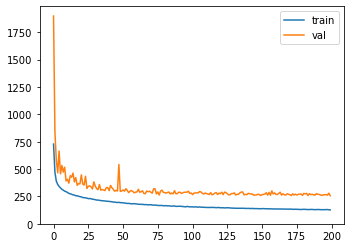

In [13]:
DECODED_LOSS_WEIGHT = 0.5
OUTPUTS_LOSS_WEIGHT = 0.5

mlflow.log_param("decoded loss weight", DECODED_LOSS_WEIGHT)
mlflow.log_param("outputs loss weight", OUTPUTS_LOSS_WEIGHT)

losses = {
    "decoded": vae_loss,
    "outputs": "binary_crossentropy"
}

loss_weights = {
    "decoded": DECODED_LOSS_WEIGHT,
    "outputs": OUTPUTS_LOSS_WEIGHT
}

metrics = {
    "outputs": ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc]
}
METRIC_TO_MONITOR = "val_outputs_fbeta"

outputs_train = {
    "decoded": x_train,
    "outputs": y_train
}

outputs_valid = {
    "decoded": x_val,
    "outputs": y_val
}

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="multilearner_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode="max", verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode="max", patience=50, verbose=1, restore_best_weights=True)
]

hist = model.fit(
    x=x_train,
    y=outputs_train,
    batch_size=32,
    epochs=200,
    validation_data=(x_val, outputs_valid),
    callbacks=list_callbacks
)

plot.keras_hist(hist.history)

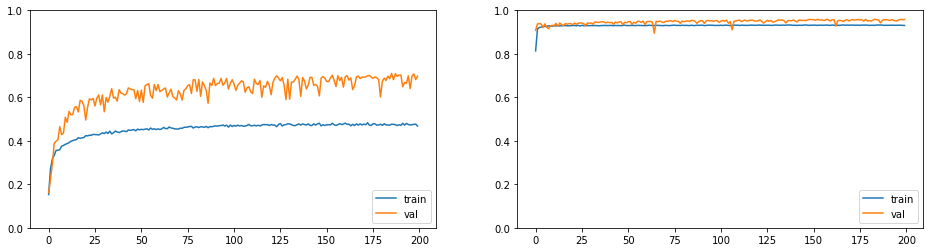

In [14]:
history = hist.history

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(history['outputs_matthews_correlation_coefficient'], label='train')
plt.plot(history['val_outputs_matthews_correlation_coefficient'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history['outputs_fbeta'], label='train')
plt.plot(history['val_outputs_fbeta'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

# Test Model

[0 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1]
[1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1]


Text(0.5, 1.0, 'decoded image')

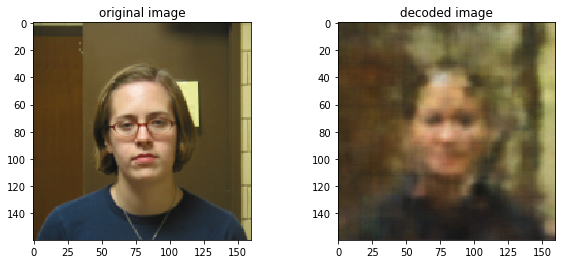

In [23]:
random_idx = np.random.choice(x_val.shape[0])
im = np.expand_dims(x_val[random_idx], axis=0)
y_true = y_val[random_idx] 

y_pred_decoded, y_pred_outputs = model.predict(im)
y_pred_outputs = np.where(y_pred_outputs > 0.5, 1, 0)

print(y_true, y_pred_outputs[0], sep='\n')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(im.squeeze()[:, :, ::-1])
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(y_pred_decoded.squeeze()[:, :, ::-1])
plt.title('decoded image')

# Save Classification Model 

In [16]:
FILE_MODEL_CLF = FILE_MODEL.replace('multilearner', 'model')
print(FILE_MODEL_CLF)

model_clf = Model(inputs=model.inputs, outputs=model.get_layer('outputs').output, name="ICAOnet")
model_clf.summary()

model_clf.save(FILE_MODEL_CLF)

../../models/unsupervised_supervised/model_2020_07_19-15_49_52.h5
Model: "ICAOnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 32)        4640      
___________________________________________________________

In [17]:
import cv2
from glob import glob

model_clf = load_model(FILE_MODEL_CLF)

list_files = [PATH_TO_ROOT + 'data/cropped_faces/images/AR_FDB_m-013-17.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred_ori = model.predict(im)[1]
y_pred_clf = model_clf.predict(im)
assert(np.allclose(y_pred_ori, y_pred_clf))

for y_pred in y_pred_clf[0]:
    print(y_pred)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


../../data/cropped_faces/images/AR_FDB_m-013-17.png


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



0.95952
0.47339305
0.9986114
0.70020914
0.9819647
0.9749527
0.9155423
0.5943412
0.44811717
0.31001937
0.87769103
0.74295616
0.4077538
0.88456774
0.91437846
0.9001491
0.66023177
0.99916965
0.4862224
0.9193303
0.9995352
0.41270918
0.9982951


# Embeddings Visualization 

In [ ]:
FOLDER_LOGS = '../../logs/unsupervised_supervised/'

### Metadata 

In [ ]:
_, image_files = pkl.load(open(FILE_DUMP_IMAGES, 'rb'))
_, data, _, mrks = pkl.load(open(FILE_AUTOENCODER_SAMPLES, 'rb'))

image_files = [basename(filepath) for filepath in np.array(image_files)[x_val_idx]]
print(len(image_files))
print(data.shape)

In [ ]:
with open(f'{FOLDER_LOGS}/metadata.tsv', 'w') as metadata_file:
    for file in image_files:
        metadata_file.write(file+'\n')

mlflow.log_artifact(f'{FOLDER_LOGS}/metadata.tsv')

### Image Sprite

In [ ]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min_data = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min_data).transpose(3,0,1,2)
    max_data = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max_data).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data### Embeddings 

In [ ]:
im_sprite = images_to_sprite(data)
print(im_sprite.shape)

cv2.imwrite(f'{FOLDER_LOGS}/sprites.png', im_sprite)
mlflow.log_artifact(f'{FOLDER_LOGS}/sprites.png')

### Embeddings 

In [ ]:
model = load_model(FILE_MODEL_CLF)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

In [ ]:
emb_vectors = model_emb.predict(data)
print(emb_vectors.shape)

### Tensorboard 

In [ ]:
sess = tf.InteractiveSession()

tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
summary_writer = tf.summary.FileWriter(f'{FOLDER_LOGS}')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tf_embeddings.name
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprites.png'
embedding.sprite.single_image_dim.extend(IMAGE_SIZE)

projector.visualize_embeddings(summary_writer, config)

saver = tf.train.Saver([tf_embeddings])
sess.run(tf_embeddings.initializer)
saver.save(sess, f'{FOLDER_LOGS}/embeddings.ckpt')

sess.close()

In [ ]:
mlflow.end_run()